# Univariate Forecasting - Statistical Models

In [1]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

It is important and useful to test *simple forecast strategies* prior to testing more complex models. Simple forecast strategies are those that assume little or nothing about the nature of the forecast problem and are fast to implement and calculate. The results can be used as a *baseline in performance* and used as a *point of a comparison*. If a model can perform better than the performance of a simple forecast strategy, then it can be said to be skillful. 

Machine learning and deep learning methods can achieve impressive results on challenging time-series forecasting problems. Nevertheless, there are many forecasting problems where classical (statistical) methods such as SARIMA and exponential smoothing readily outperform more sophisticated methods. Therefore, it is important to both understand how classical time-series forecasting methods work and to evaluate them prior to exploring more advanced methods.

## Food Consumption Score Time-Series of the Yemen country

Let's load the time-series of the Adminstratas of the Yemen country (FCS indicator) with which we want to test some statistical forecasting approaches.

In [2]:
df = pd.read_excel("ts_fcs.xlsx", index_col = 0, parse_dates = True)
df.columns.name = "AdminStrata"
df.head()

AdminStrata   Abyan  Ad Dali   Aden  Al Bayda  Al Hudaydah  Al Jawf  \
Datetime                                                              
2015-09-30   34.100    57.43  21.22     32.76        32.28    37.97   
2015-10-31   40.145    54.33  38.02     46.39        37.67    49.74   
2015-11-30   46.190    56.44  27.95     52.56        32.65    56.74   
2015-12-31   36.110    53.04  30.60     54.37        25.54    58.22   
2016-01-31   43.440    50.44  26.24     55.33        32.19    55.17   

AdminStrata  Al Maharah  Al Mahwit  Amran  Dhamar  ...  Hajjah    Ibb   Lahj  \
Datetime                                           ...                         
2015-09-30        18.00      34.38  46.82   51.76  ...   52.04  48.10  41.31   
2015-10-31        25.00      34.56  45.05   58.15  ...   54.73  46.12  37.69   
2015-11-30        35.56      39.38  58.51   55.58  ...   51.95  51.04  30.62   
2015-12-31        24.82      34.31  53.84   55.84  ...   43.49  47.02  50.17   
2016-01-31        19.78      29.67  46.88   49.89  ...   52.10  51.67  48.03   

AdminStrata  Marib  Raymah     Sa'dah  Sana'a  Sana'a City  Shabwah  Taizz  
Datetime                                                                    
2015-09-30   61.71   62.84  46.230000   38.25        33.43    35.22  55.37  
2015-10-31   49.25   60.59  44.811429   40.24        36.76    42.42  57.60  
2015-11-30   45.39   65.15  43.392857   29.66        35.96    42.41  59.83  
2015-12-31   47.12   67.28  41.974286   50.51        42.51    51.00  55.53  
2016-01-31   45.62   64.38  40.555714   52.91        38.82    57.95  62.71  

[5 rows x 21 columns]

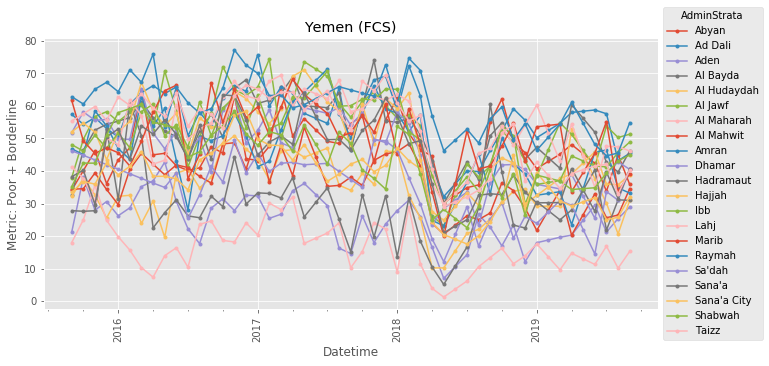

In [3]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
df.plot(ax = f.gca(), style = ".-")
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

In [4]:
# Let's define the number of observation we want to predict.
num_predictions = 1
# Let's define the 'train' and 'test' sets.
num_train = len(df) - num_predictions
df_train = df[:num_train]
df_test = df[num_train:]
print("The number of points used to forecast is:", len(df_train))
print("The number of points to use for testing the forecast is:", len(df_test))

The number of points used to forecast is: 48
The number of points to use for testing the forecast is: 1


In [5]:
dates_to_forecast = df_test.index
dates_to_forecast.array

<DatetimeArray>
['2019-09-30 00:00:00']
Length: 1, dtype: datetime64[ns]

In [6]:
# Define the dictionary where save the results of all the forecast methods tried.
results_forecast = dict()

## 1.  Naive Forecast

Naive model is a persistence model that simply uses the last observation of the corresponding time-series as prediction of the next time step. Given a time-series $X = \{x_1, x_2, ..., x_t\}$, let's suppose to want to predict the next $x_{t + 1}$ value.
The Naive model chooses as prediction:

$$\hat{y} = x_t$$

where $\hat{y}$ is the prediction for the $x_{t + 1}$ value.

This simple approach can be adjusted slightly for seasonal data. In this case, the observation at the same time in the previous cycle may be persisted instead. This can be further generalized to testing each possible offset into the historical data that could be used to persist a value for a forecast. For example, setting the offset not to the last observation $x_t$ but to quintultimate observation $x_{t - 5}$:

$$\hat{y} = x_{t - 5}$$

Let's search for the best $n$ parameter (previous lags for the Naive method, $x_{t - n}$) for each AdminStrata using a grid search.

In [7]:
def evaluate_naive_forecast(time_series, n):
    for i in range(num_predictions):
        # Make prediction.
        y_hat = time_series[-n] 
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    #error = mean_absolute_error(df_test[time_series.name], y_hats)
    error = np.sqrt(mean_squared_error(y_true = df_test[time_series.name], 
                                       y_pred = y_hats))
    return error, n, y_hats

In [8]:
def naive_forecast(time_series):    
    ns = len(time_series)
    best_score, best_n, best_y_hats = float("inf"), None, None
    # Grid search for the best n parameter.
    with tqdm(total = ns + 1, disable = False, leave = False, desc = time_series.name, ascii = True) as progress_bar: 
        for n_ in range(1, ns + 1):
            try:
                error, n, y_hats = evaluate_naive_forecast(time_series, n_)
                if error < best_score:
                    best_score, best_n, best_y_hats = error, n, y_hats
            except:
                continue    
                
            progress_bar.update(1) 
    
    return best_score, best_n, best_y_hats

In [9]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(naive_forecast)
err = np.mean([x[0] for x in results])
err

0.24520408163265422

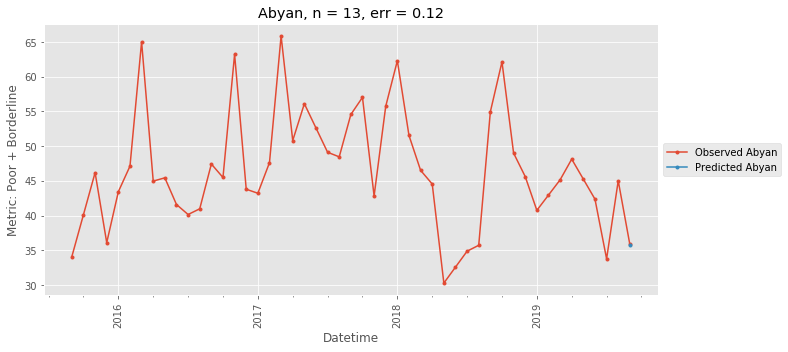

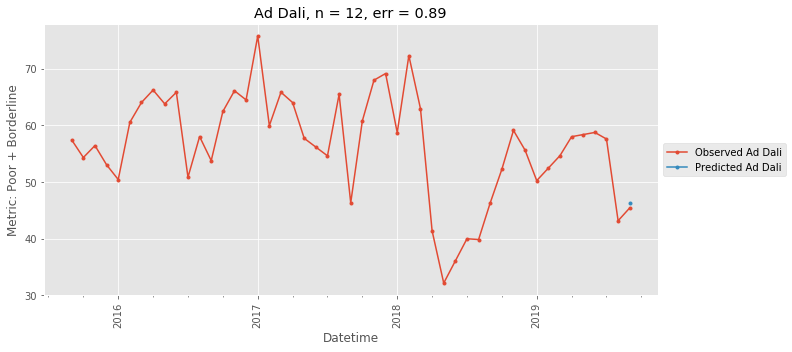

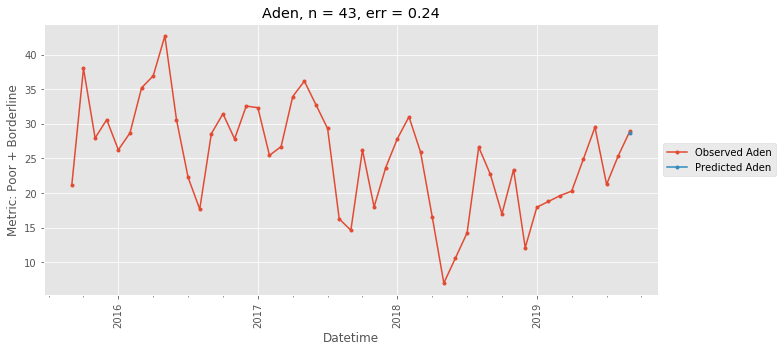

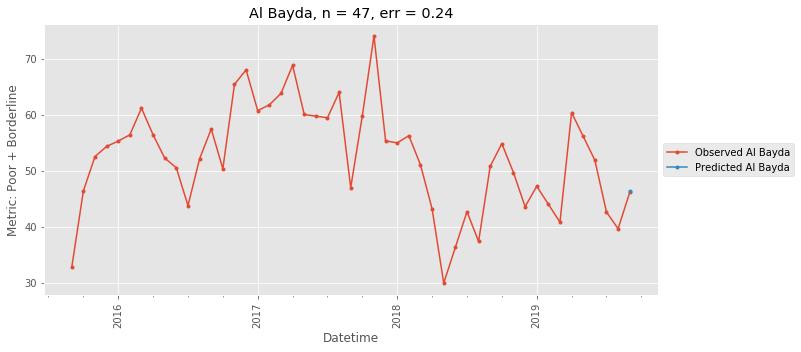

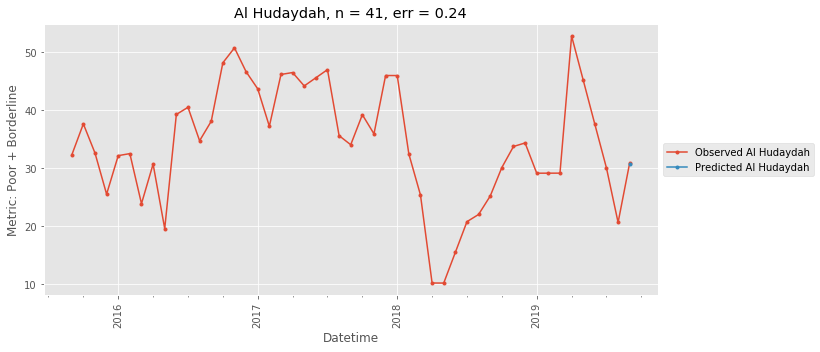

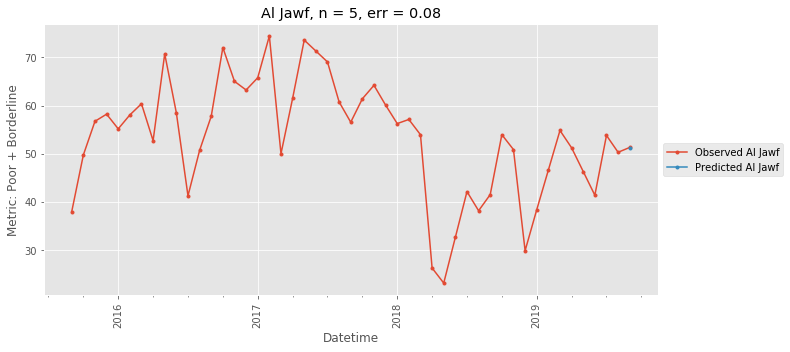

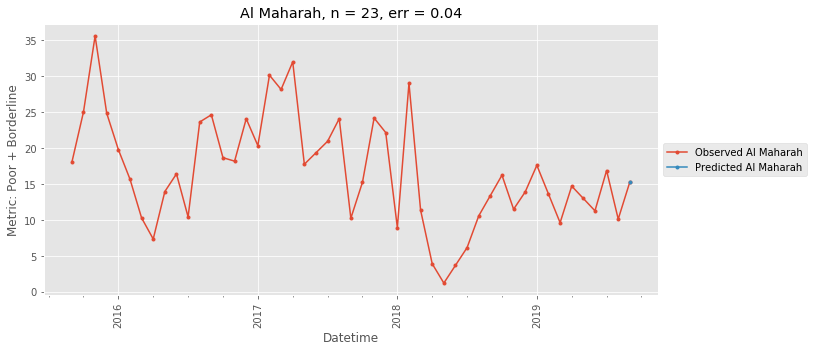

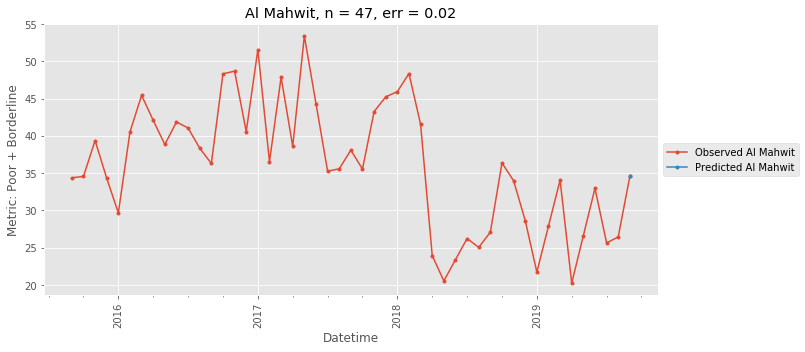

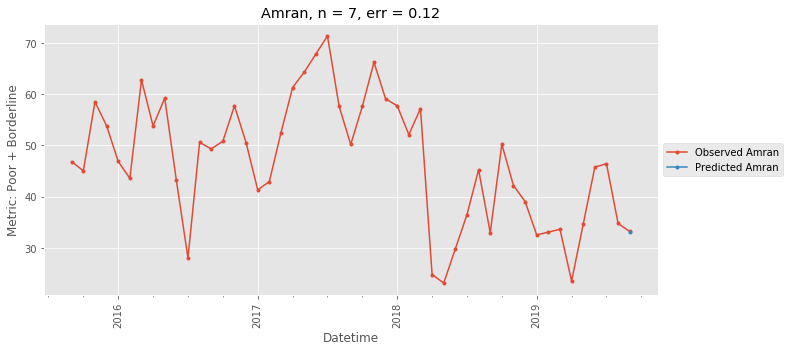

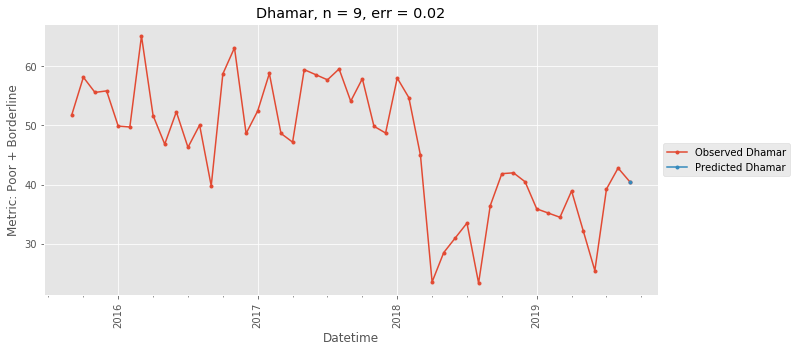

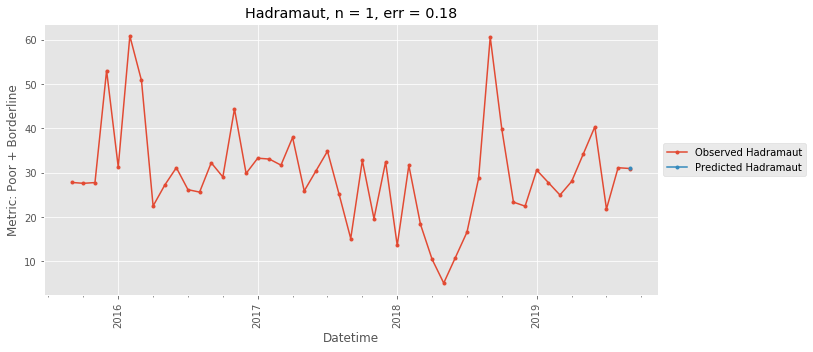

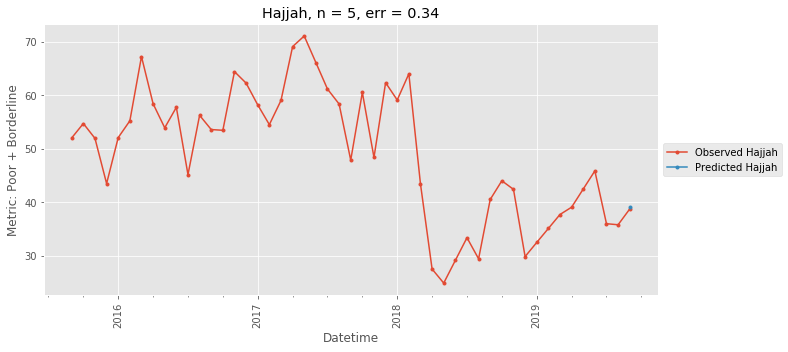

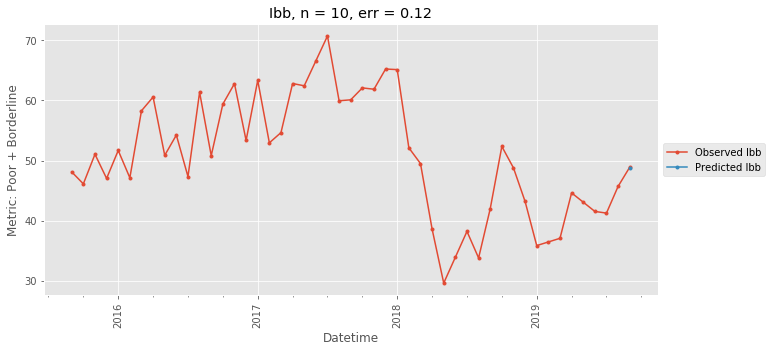

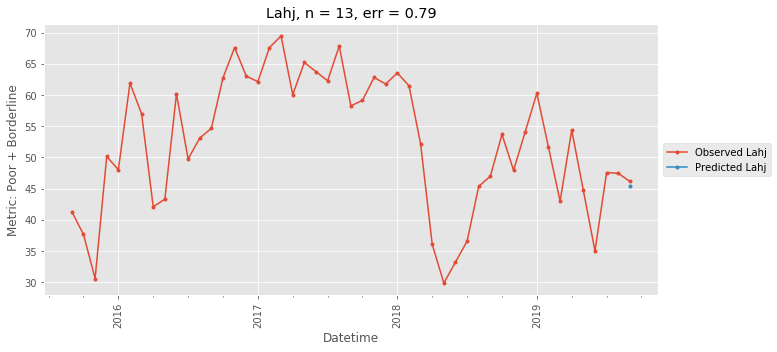

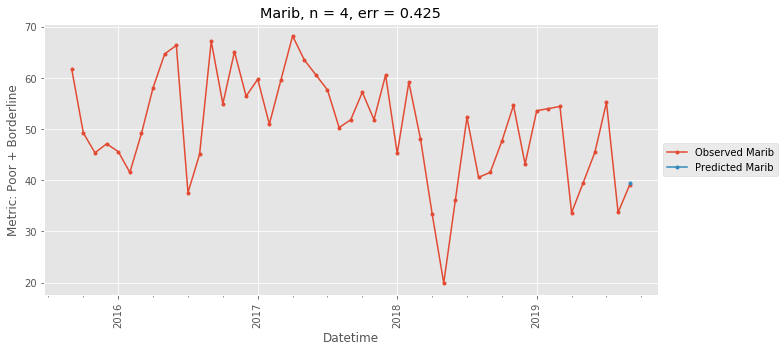

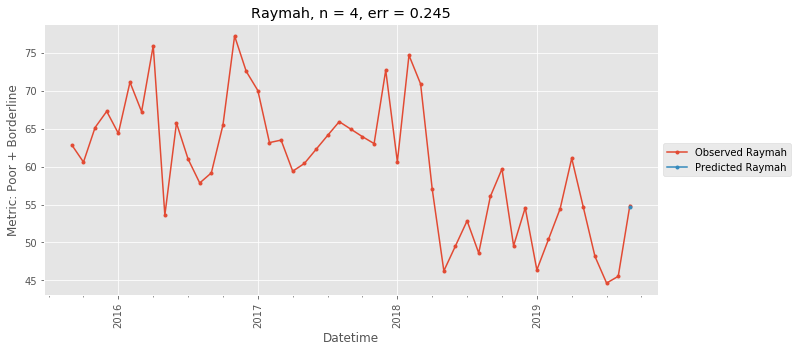

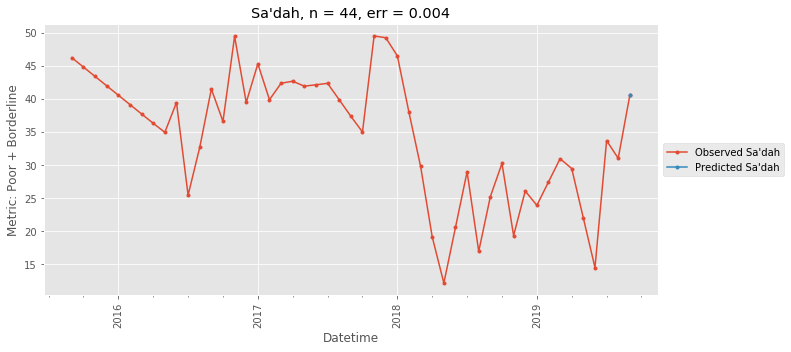

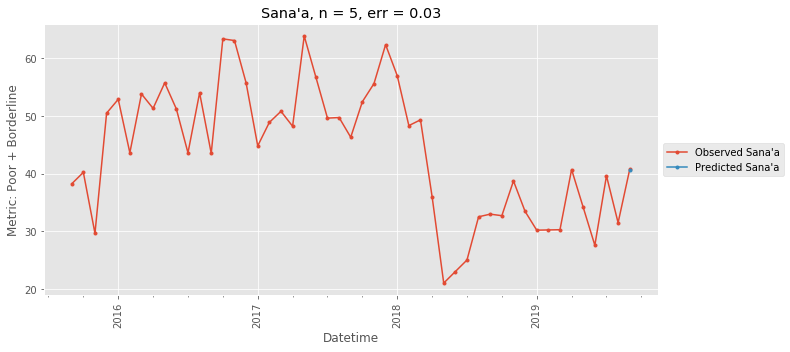

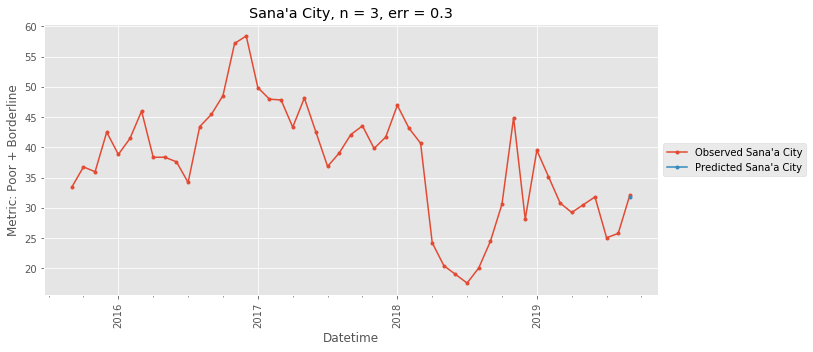

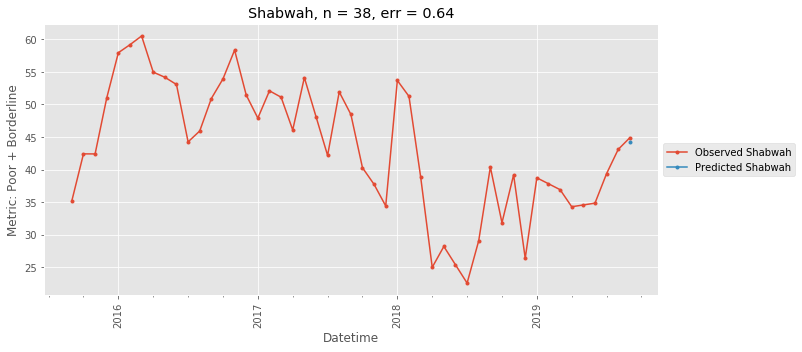

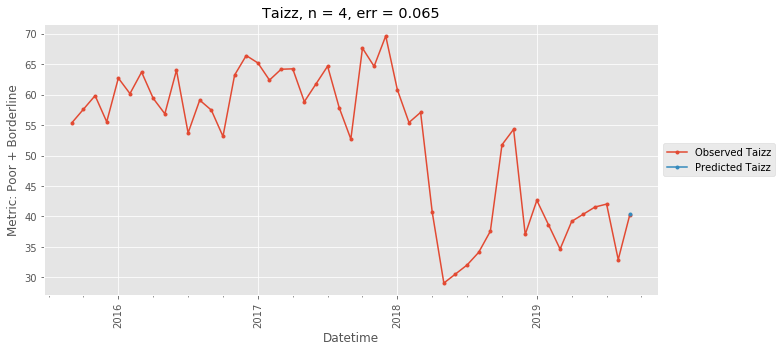

In [10]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "n = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [11]:
results_forecast["Naive"] = err

## 2.  Average Forecast

The average model averages the last $n$ observations. Assuming for example that $n = 3$:

$$\hat{y} = \frac{x_{t - 2} + x_{t - 1} + x_t}{3}$$

where $\hat{y}$ is the prediction for the $x_{t + 1}$ value. Let's search for the best $n$ parameter (previous lags for the Avergae model, $x_{t - n}$) for each AdminStrata using a grid search.

In [12]:
def evaluate_average_forecast(time_series, n):
    for i in range(num_predictions):
        # Make prediction.
        y_hat = np.mean(time_series[-n:])
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = np.sqrt(mean_squared_error(y_true = df_test[time_series.name], 
                                       y_pred = y_hats))
    return error, n, y_hats

In [13]:
def average_forecast(time_series):    
    ns = len(time_series)
    best_score, best_n, best_y_hats = float("inf"), None, None
    # Grid search for the best n parameter.
    with tqdm(total = ns + 1, disable = False, leave = False, desc = time_series.name, ascii = True) as progress_bar: 
        for n_ in range(1, ns + 1):
            try:
                error, n, y_hats = evaluate_average_forecast(time_series, n_)
                if error < best_score:
                    best_score, best_n, best_y_hats = error, n, y_hats
            except:
                continue    
                
            progress_bar.update(1) 
            
    return best_score, best_n, best_y_hats

In [14]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(average_forecast)
err = np.mean([x[0] for x in results])
err

1.0523008758858592

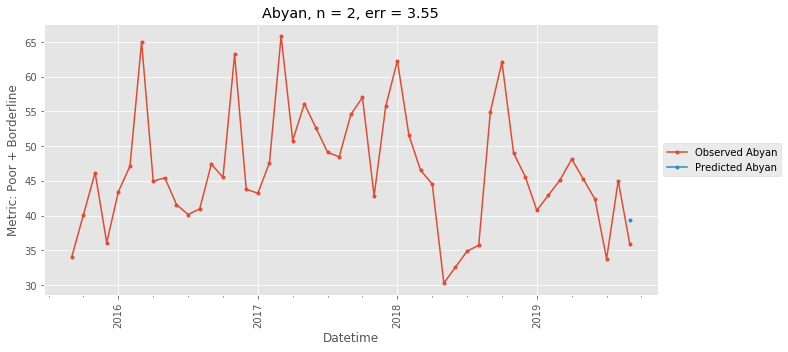

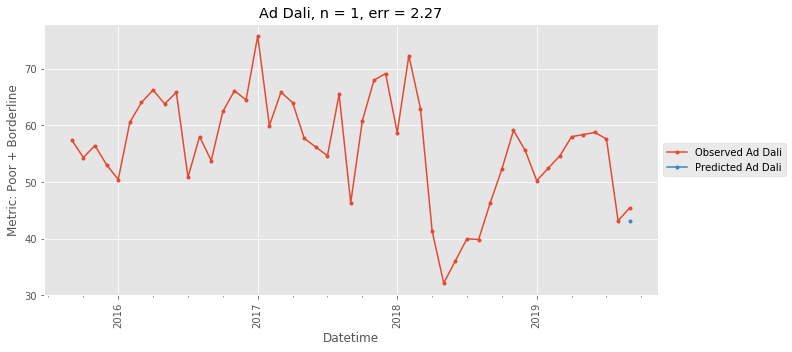

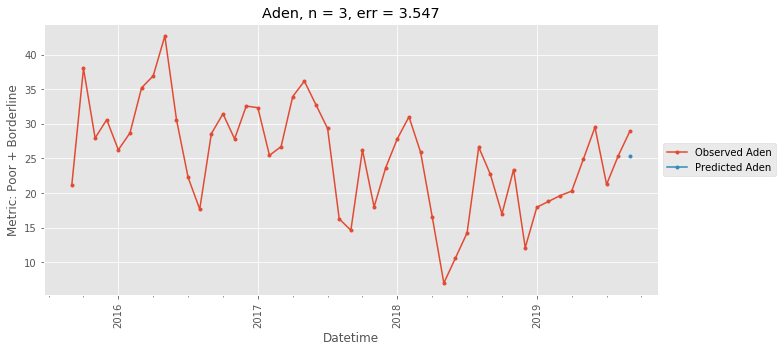

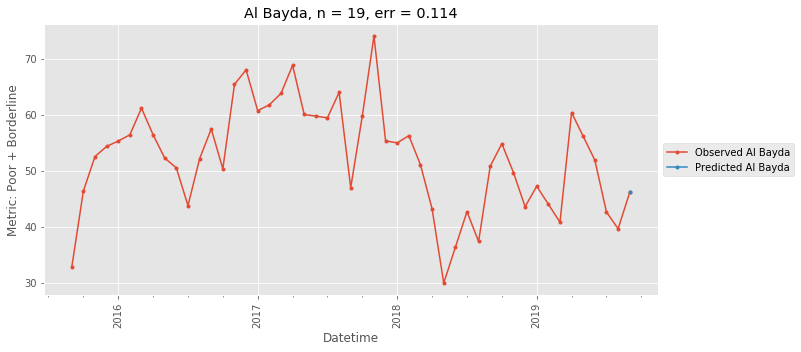

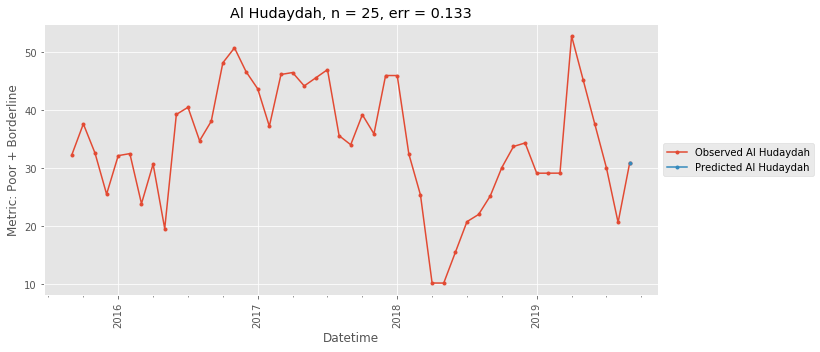

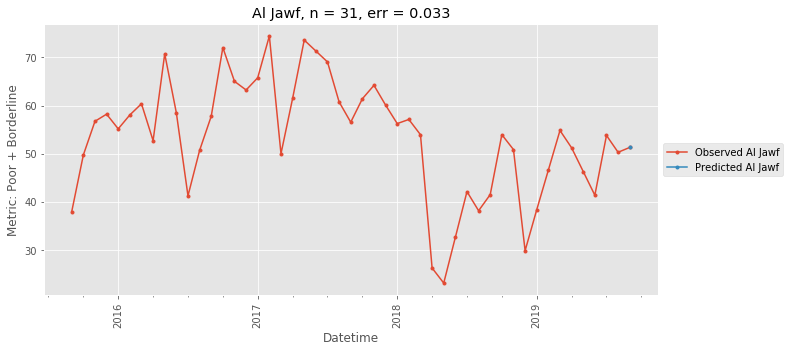

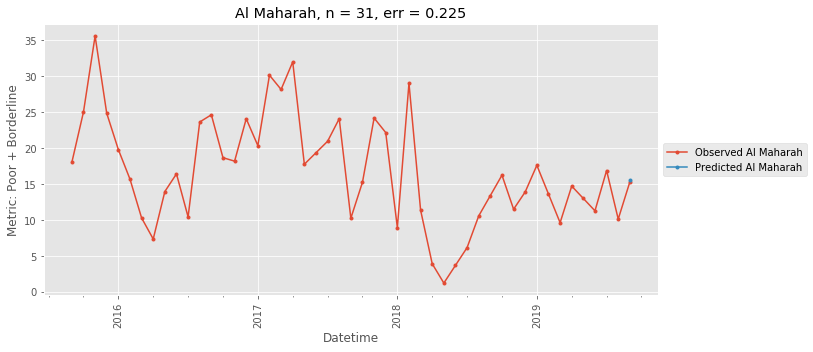

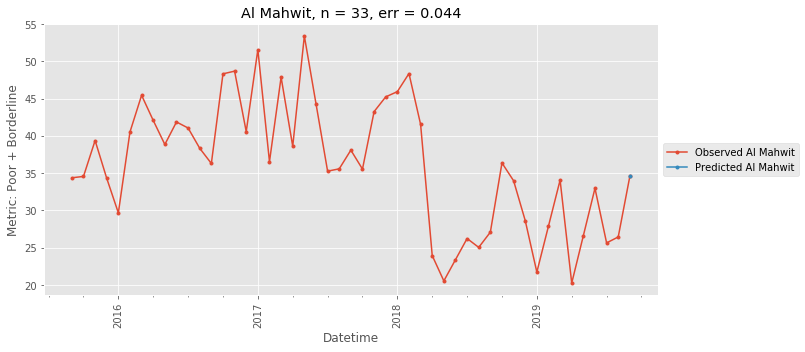

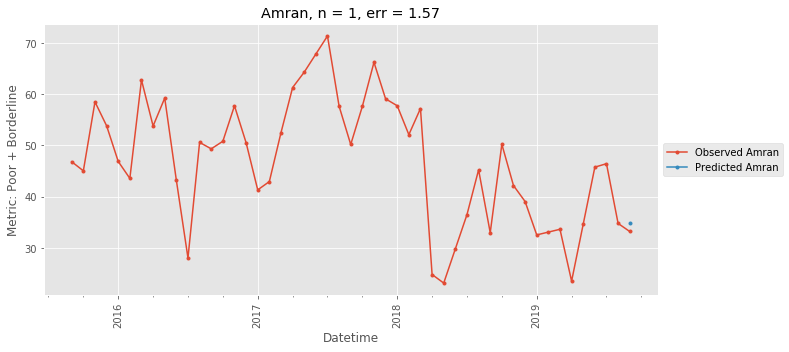

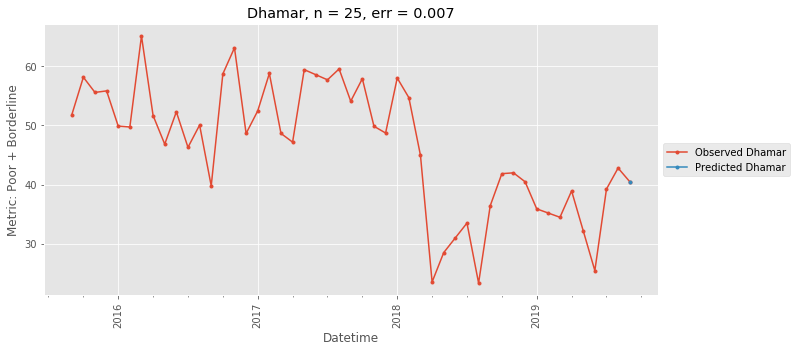

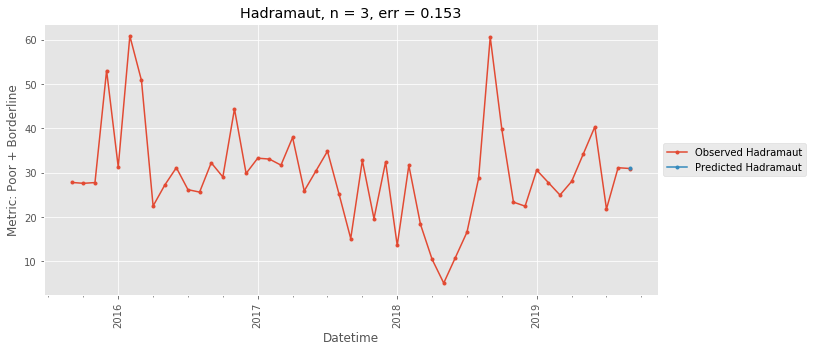

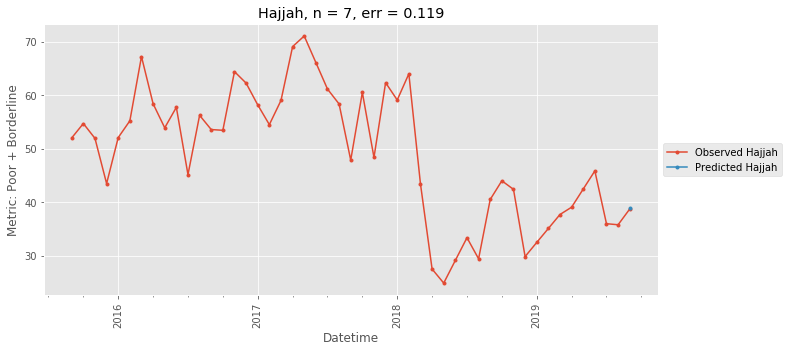

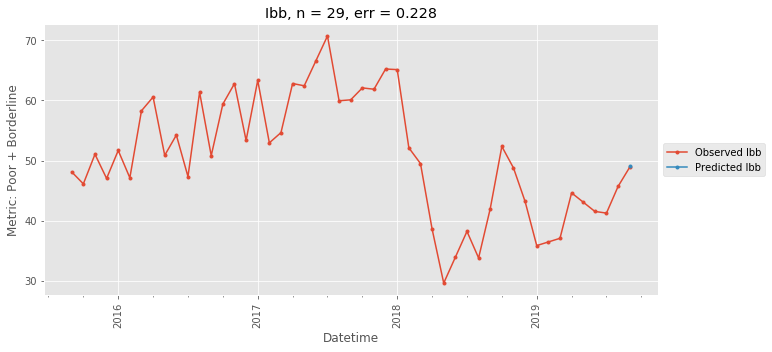

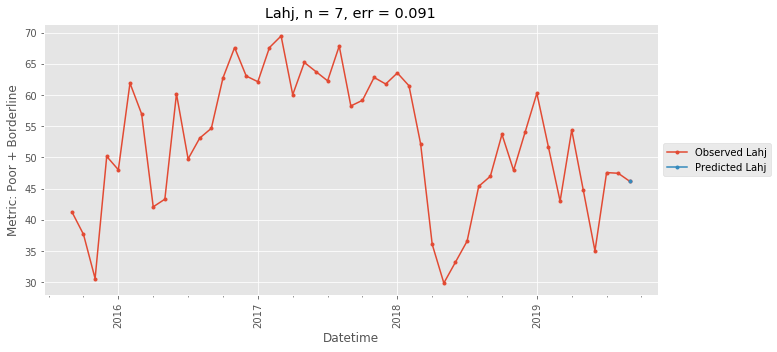

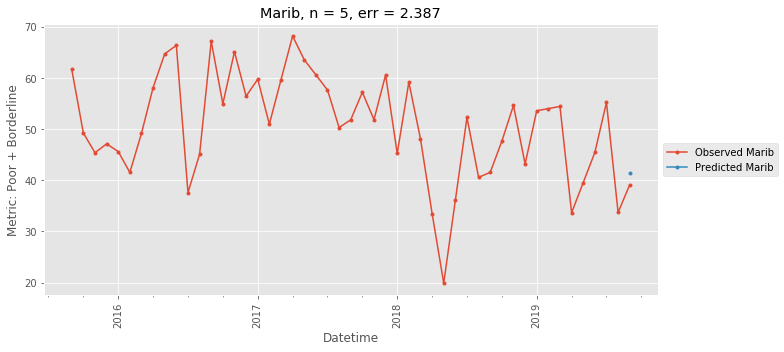

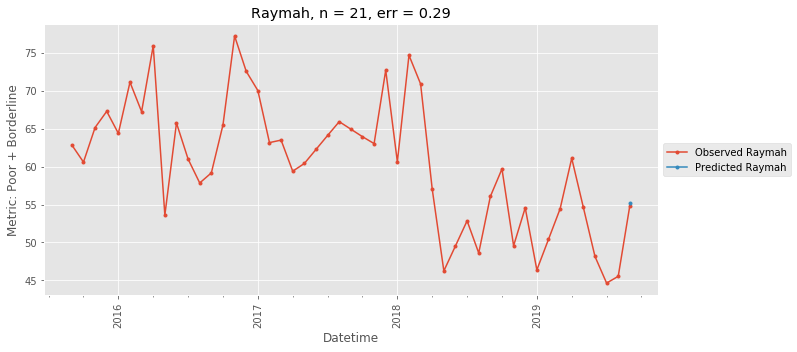

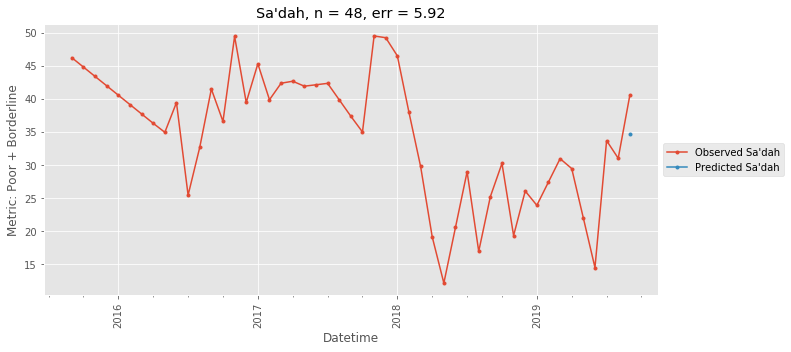

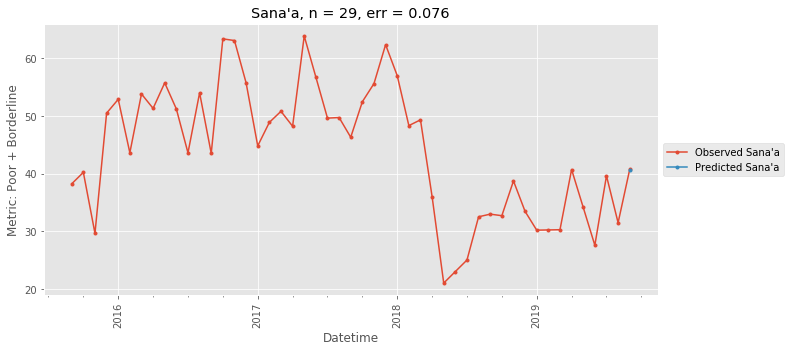

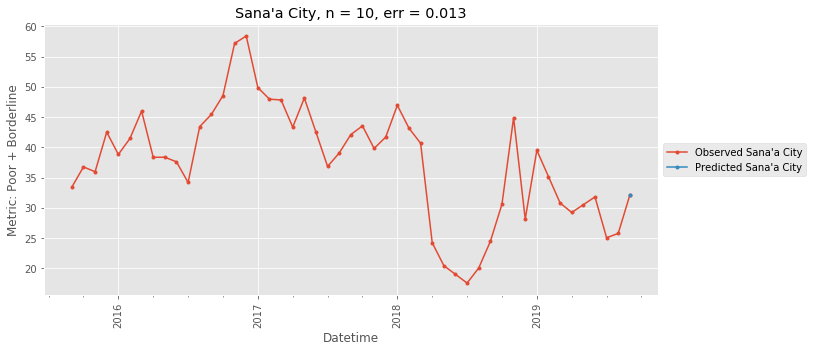

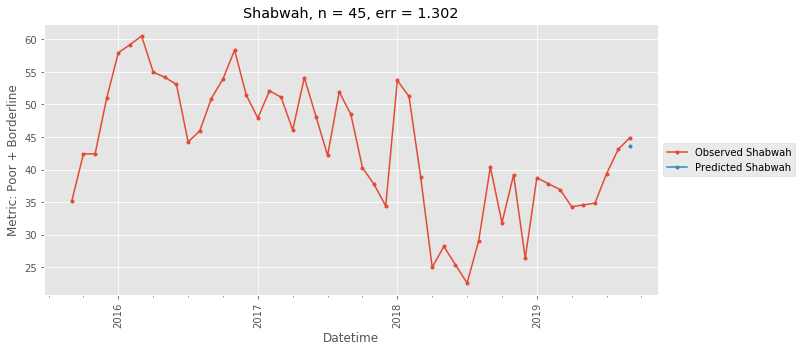

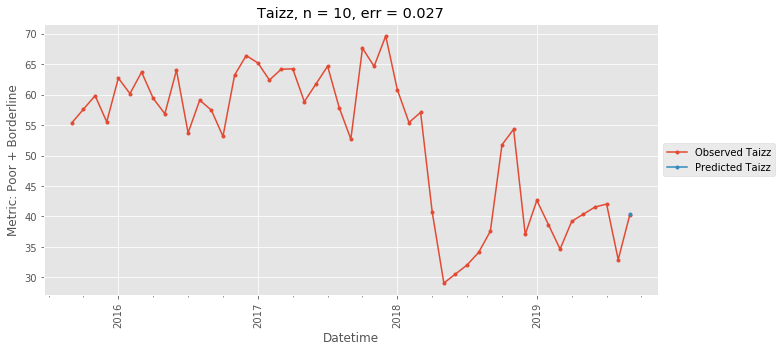

In [15]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "n = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [16]:
results_forecast["Average"] = err

## 3.  Autoregression (AR) Forecasting

Autoregression is a time-series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. A regression model, such as linear regression, models an output value based on a linear combination of input values (previous time step in our case). Formally, given a time-series $X = \{x_1, x_2, ..., x_t\}$, with $t$ observations, let's suppose to want to predict the next $x_{t + 1}$ value. The regression model predicts that value following a regression equation where input variables are taken from previous time steps, called *lag variables*. For example, we can predict the value for the next time step ($t + 1$) given the observations at the last two time steps ($t - 1$ and $t - 2$). As a regression model, this would look as follows:

$$\hat{y} = b_0 + b_1 x_{t - 1} + b_2  x_{t}$$

where $\hat{y}$ is the prediction for the $x_{t + 1}$ value, $b_0$, $b_1$ and $b_2$ are coefficients found by optimizing the model on training data. Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

We calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables $p$ to use. Let's search for the best $p$ parameter of each AdminStrata using a grid search.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
def evaluate_AR_forecast(time_series, p):
    for i in range(num_predictions):
        # Make prediction.
        model = LinearRegression()
        model_fit = model.fit(np.arange(0, len(time_series[-p:]), 1).reshape(-1, 1), time_series[-p:].values.reshape(-1, 1))
        y_hat = model_fit.predict([[len(time_series[-p:]) + 1]])[0][0]
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = np.sqrt(mean_squared_error(y_true = df_test[time_series.name], 
                                       y_pred = y_hats))
    return error, p, y_hats

In [19]:
def AR_forecast(time_series):
    ps = len(time_series)
    best_score, best_p, best_y_hats = float("inf"), None, None
    # Grid search for the best n parameter.
    with tqdm(total = ps + 1, disable = False, leave = False, desc = time_series.name, ascii = True) as progress_bar: 
        for p_ in range(1, ps + 1):
            try:
                error, p, y_hats = evaluate_AR_forecast(time_series, p_)
                if error < best_score:
                    best_score, best_p, best_y_hats = error, p, y_hats
            except:
                continue    
                
            progress_bar.update(1) 
            
    return best_score, best_p, best_y_hats

In [20]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(AR_forecast)
err = np.mean([x[0] for x in results])
err

0.7895322208273947

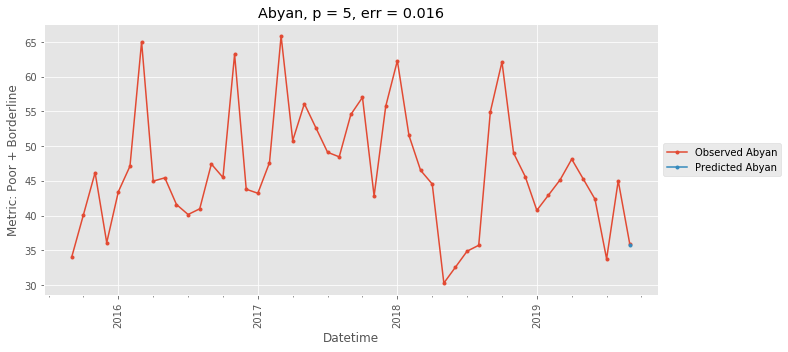

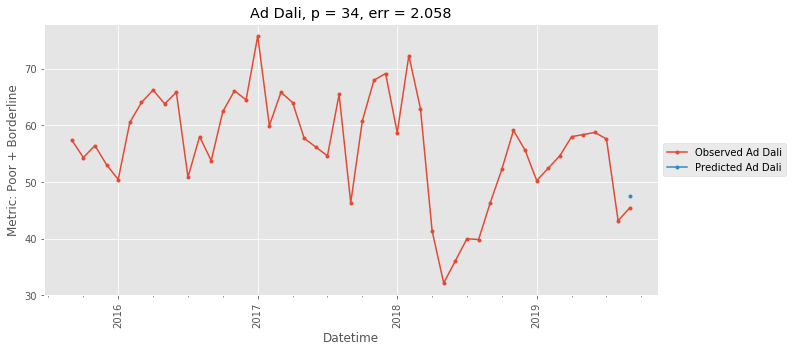

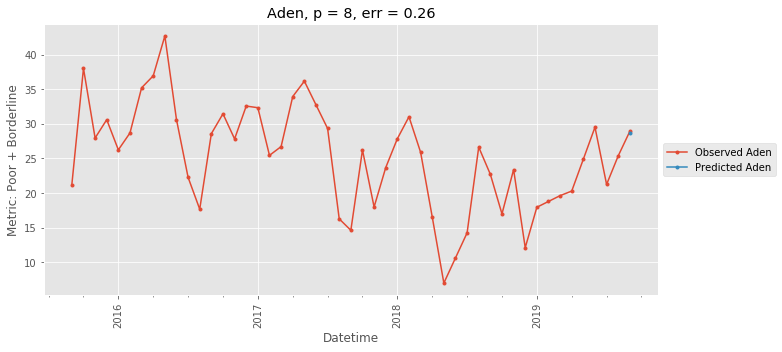

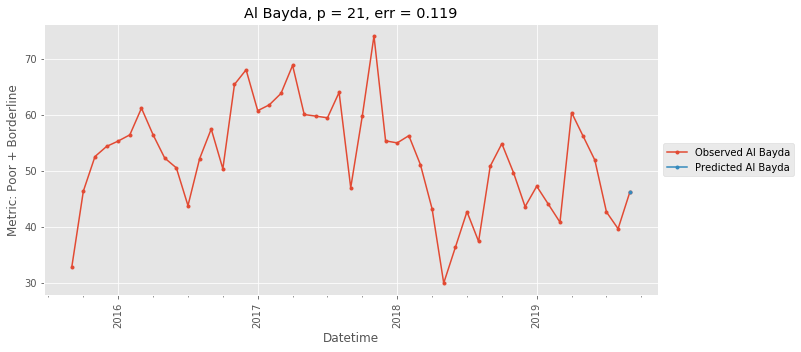

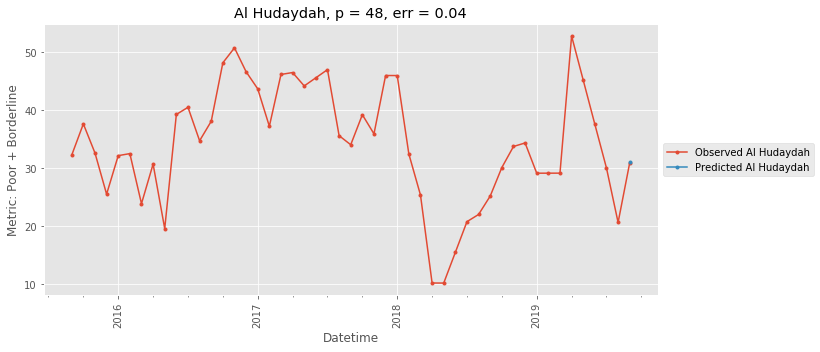

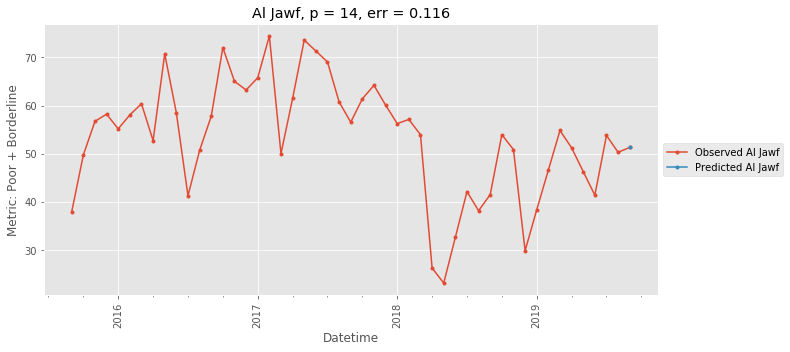

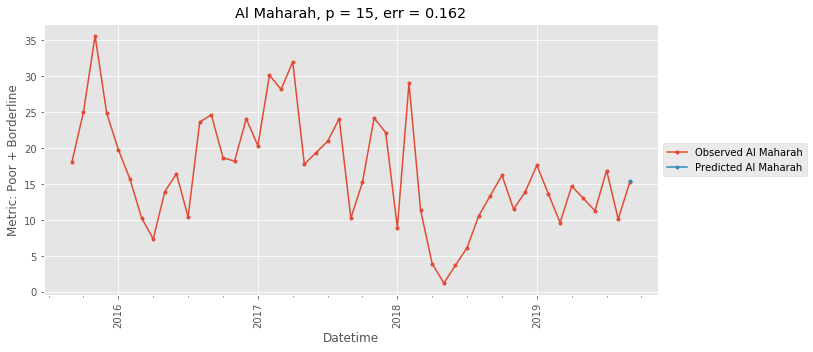

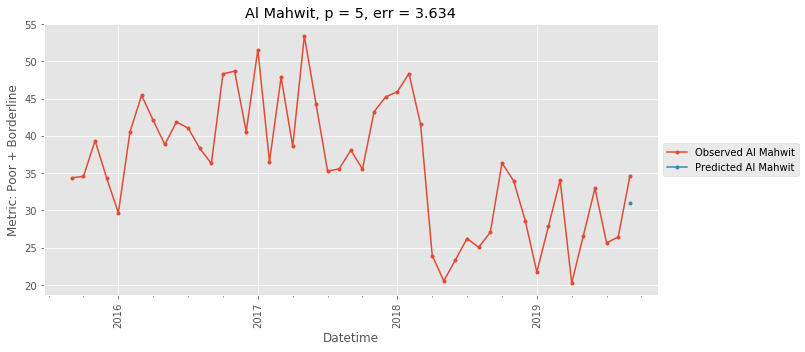

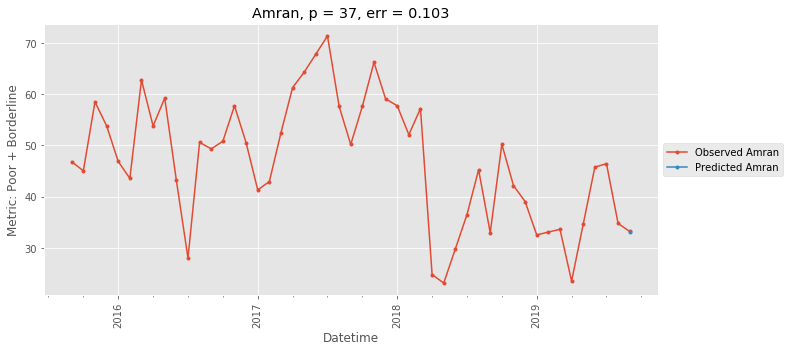

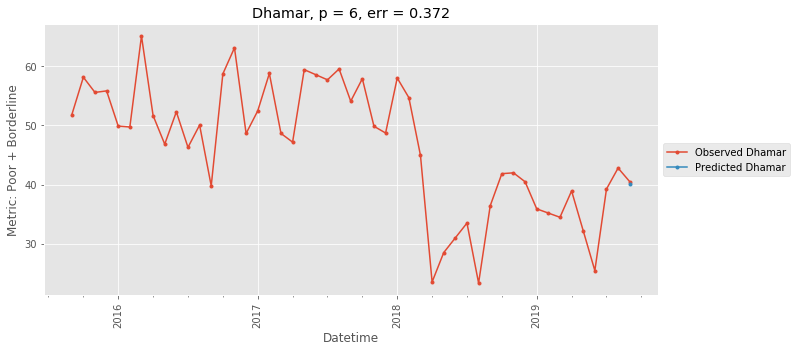

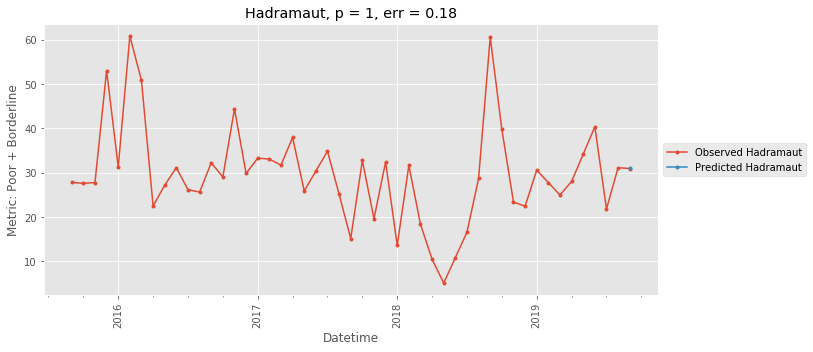

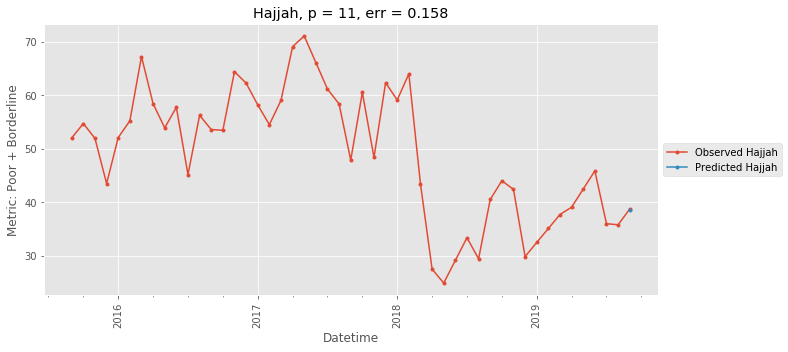

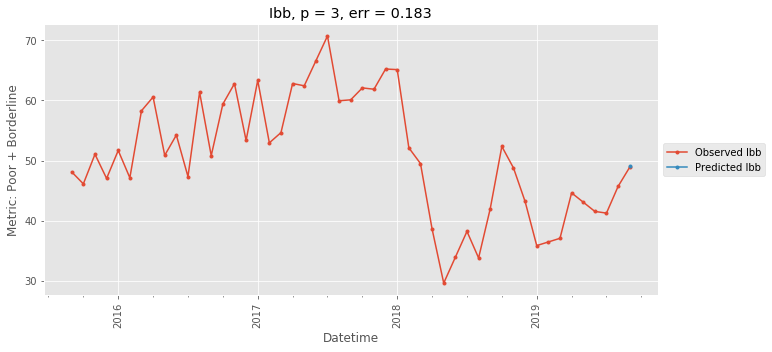

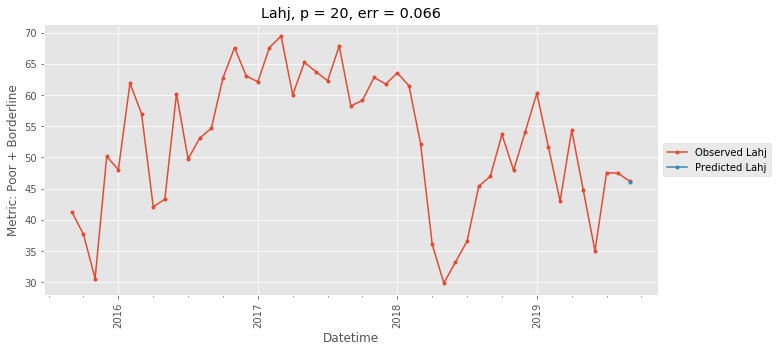

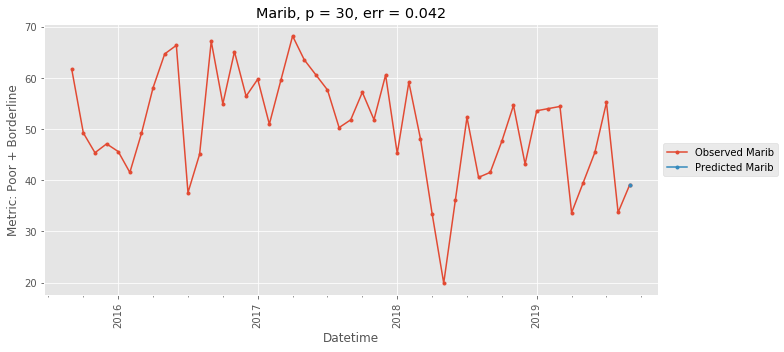

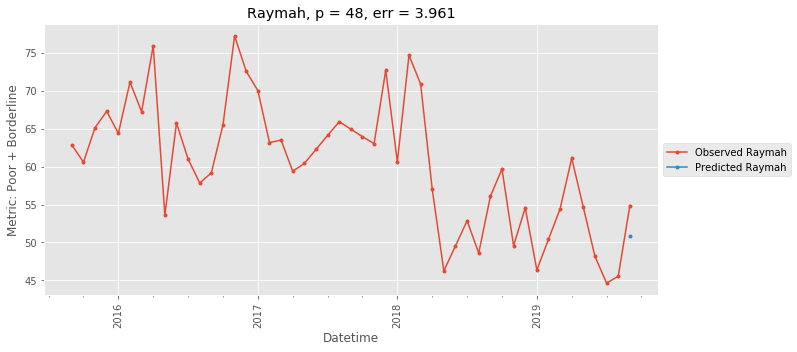

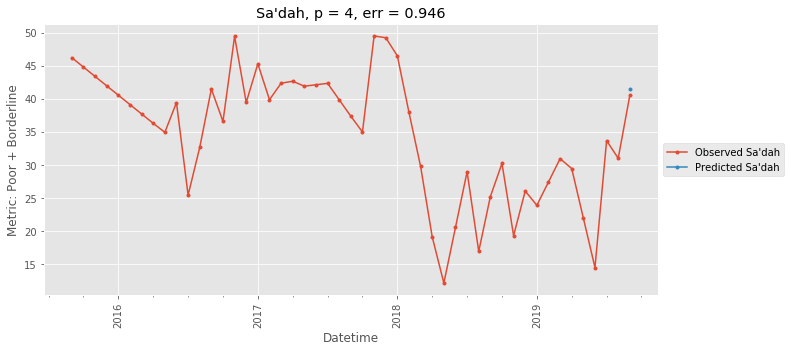

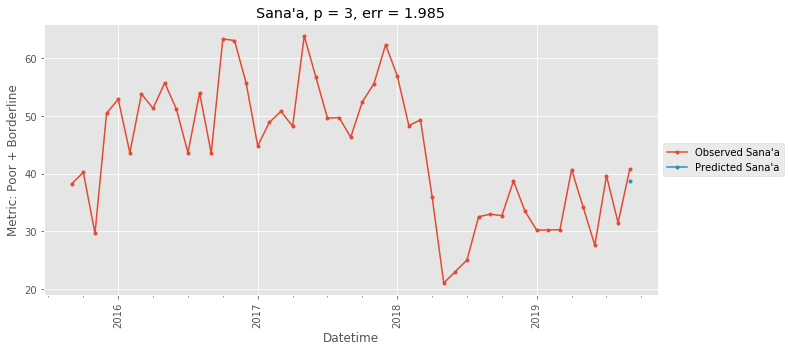

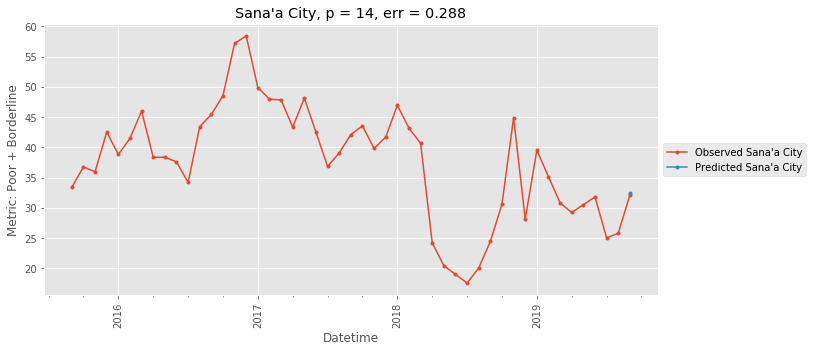

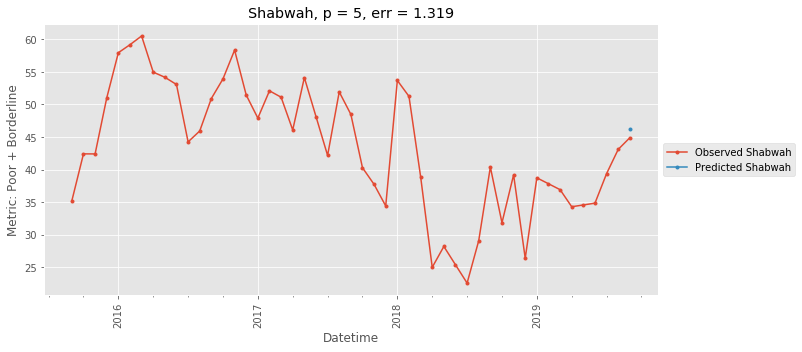

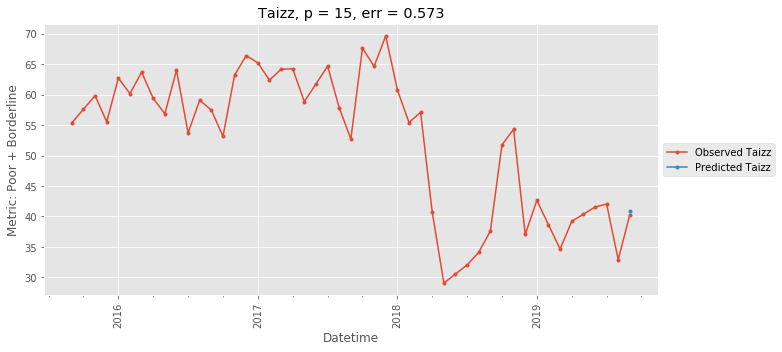

In [21]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "p = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [22]:
results_forecast["AR"] = err

## 4.  Autoregressive Integrated Moving Average (ARIMA) Forecasting

The Autoregressive Integrated Moving Average (ARIMA) is a class of statistical models for analyzing and forecasting time-series data.

It combines both Autoregression (AR) with p order and Moving Average (MA) with q order models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I) with d order. It combines both Autoregression (AR) and Moving Average (MA) models:

$$\hat{y} = \epsilon_t + \alpha_1 \epsilon_{t - 1} + \alpha_2 \epsilon_{t - 2} + ... + \alpha_q \epsilon_{t - q} + b_0 + b_1 x_{t} + b_2  x_{t - 1} + ... + b_p x_{t - p}$$

but adding the integration operation to render stationary the time-series.

The user must specify a tuple of p, d, and q ARIMA parameters. We want to perform a grid search for finding the best setting of these parameters. The statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. 

A problem with ARIMA is that it does not support seasonal data.

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
def evaluate_ARIMA_model(time_series, arima_order):
    for i in range(num_predictions):
        # Make prediction.
        model = ARIMA(time_series, order = arima_order)
        model_fit = model.fit()
        y_hat = model_fit.forecast()[0]
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = np.sqrt(mean_squared_error(y_true = df_test[time_series.name], 
                                       y_pred = y_hats))
    return error, arima_order, y_hats

In [25]:
def ARIMA_forecast(time_series):
    # Grid search of the p, d and q parameters of the ARIMA model.
    p = d = q = range(0, 2)
    # All the combination of the parameters.
    arima_orders = list(itertools.product(p, d, q))
    best_score, best_arima_order, best_y_hats = float("inf"), None, None
    with tqdm(total = len(arima_orders), disable = False, leave = False, desc = time_series.name, ascii = True) as progress_bar: 
        for arima_order_ in arima_orders:
            try:
                error, arima_order, y_hats = evaluate_ARIMA_model(time_series, arima_order_)
                if error < best_score:
                    best_score, best_arima_order, best_y_hats = error, arima_order, y_hats
            except:
                continue    
                
            progress_bar.update(1) 
            
    # Forecast.
    return best_score, best_arima_order, best_y_hats

In [26]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(ARIMA_forecast)
err = np.mean([x[0] for x in results])
err

Abyan:   0%|                                                                                     | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Abyan:  25%|###################2                                                         | 2/8 [00:00<00:00, 19.86it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency informatio

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Al Bayda:   0%|                                                                                  | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Al Maharah:   0%|                                                                                | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Dhamar:   0%|                                                                                    | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

Hajjah:  88%|##################################################################5         | 7/8 [00:00<00:00, 31.11it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Ibb:   0%|                                                                                       | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency informatio

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Raymah:   0%|                                                                                    | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Sana'a City:   0%|                                                                               | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


1.7347854999453636

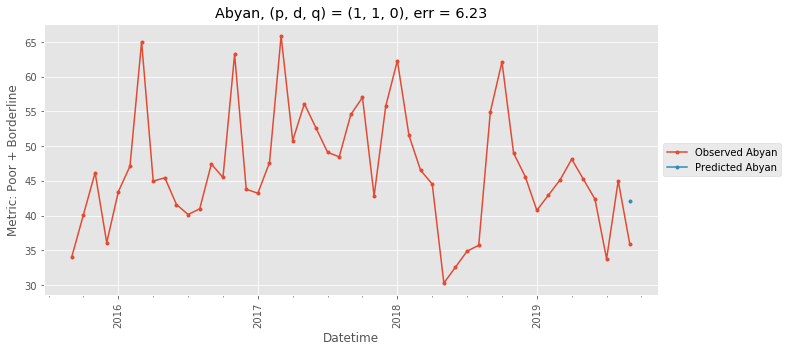

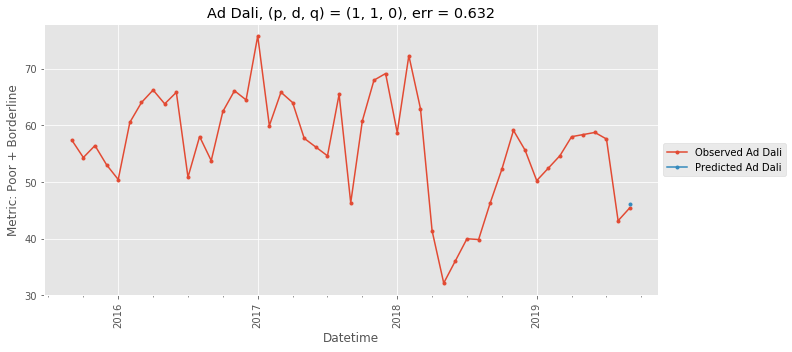

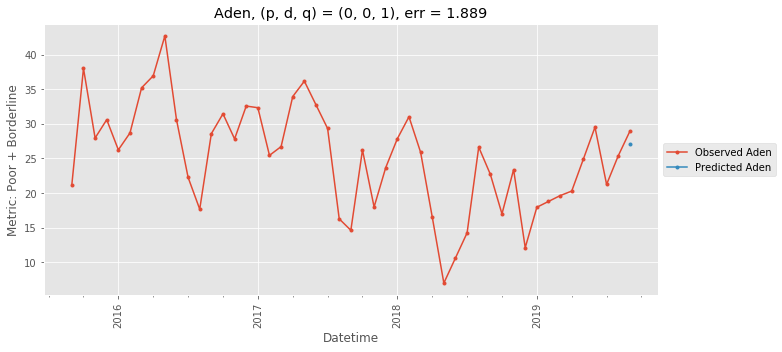

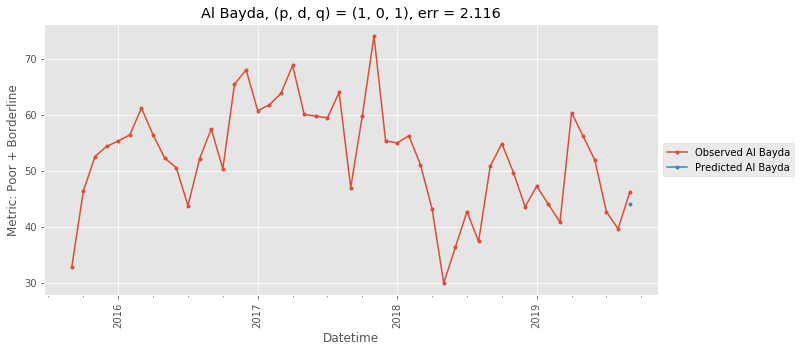

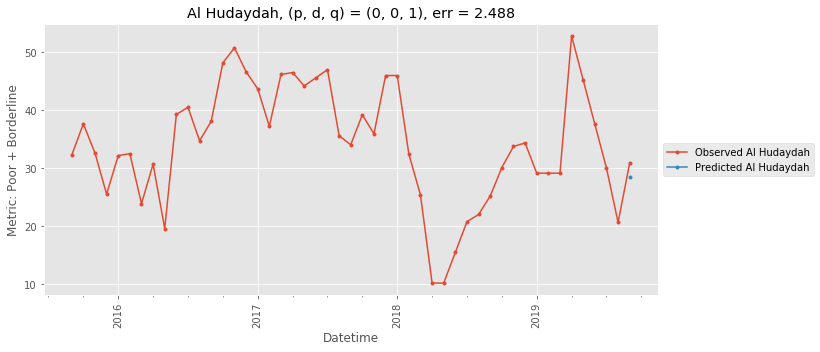

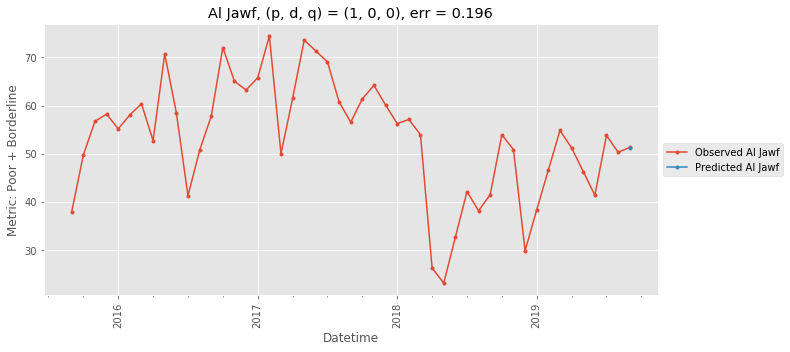

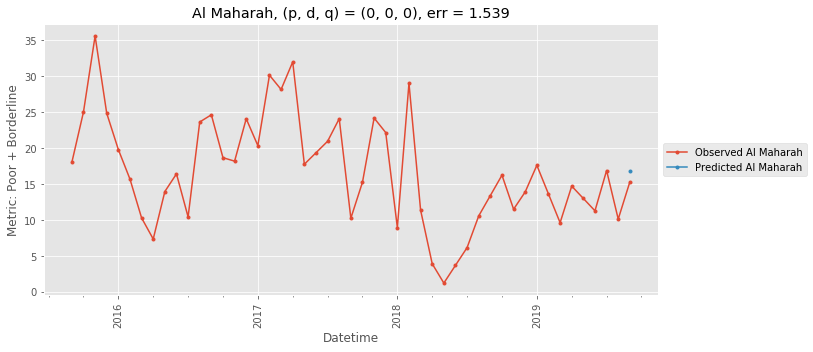

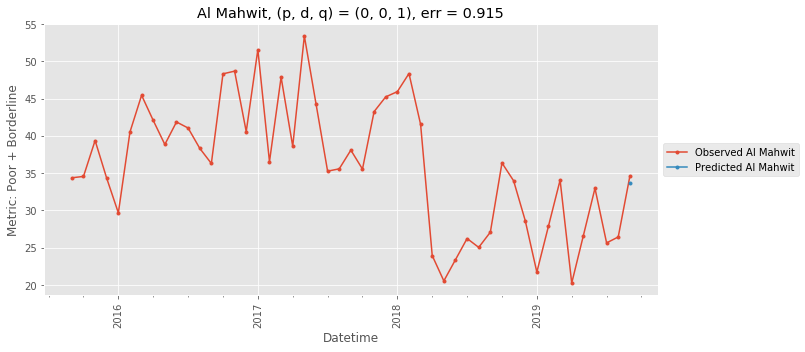

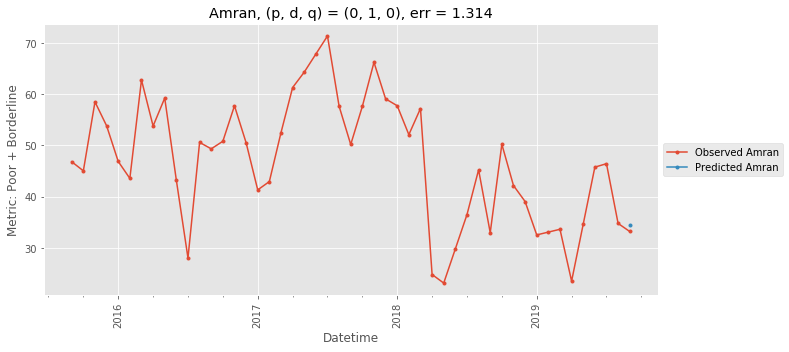

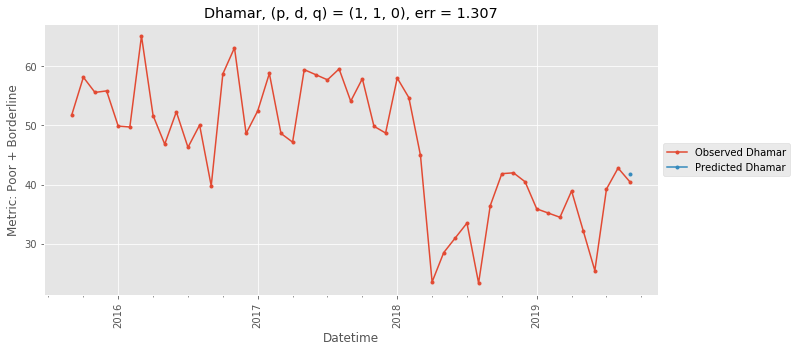

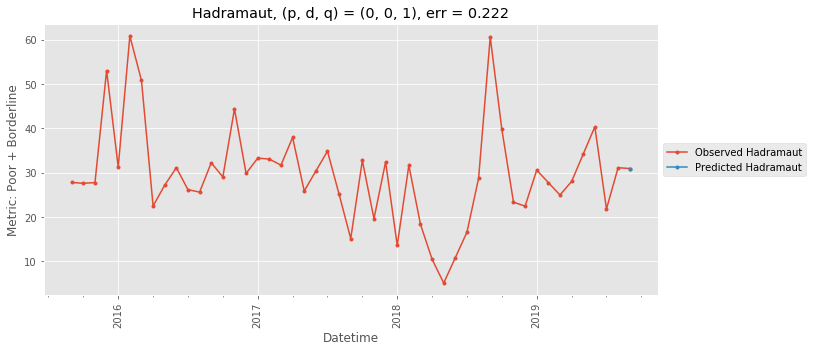

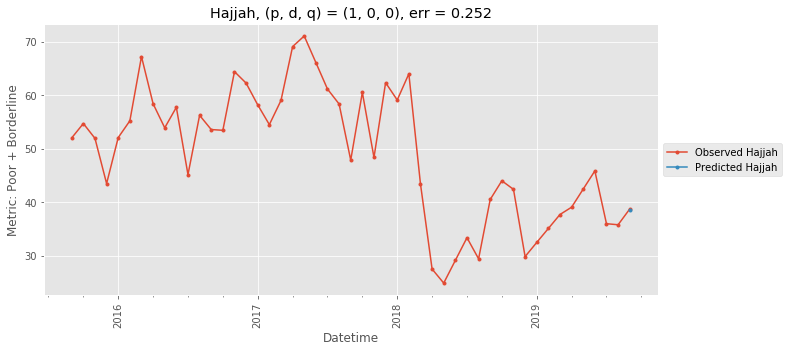

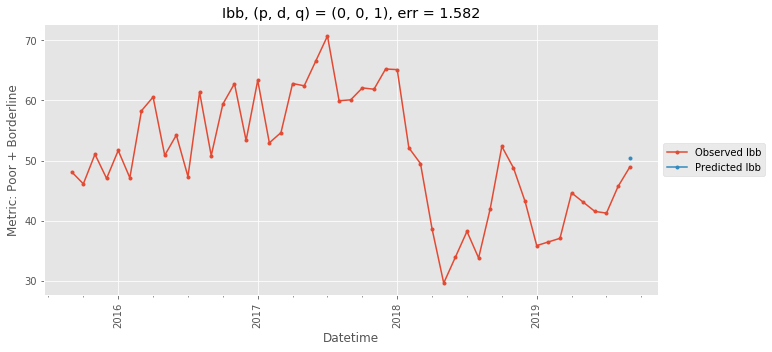

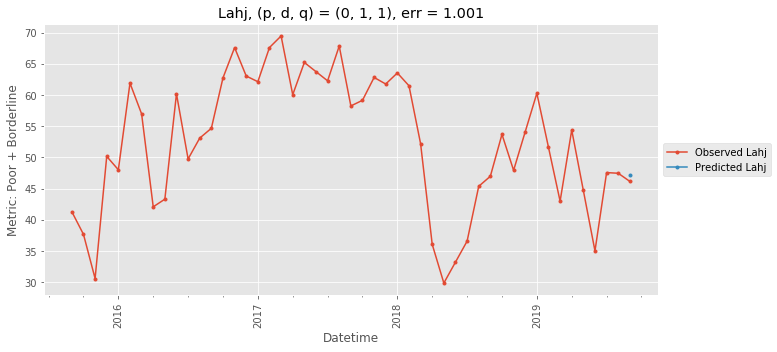

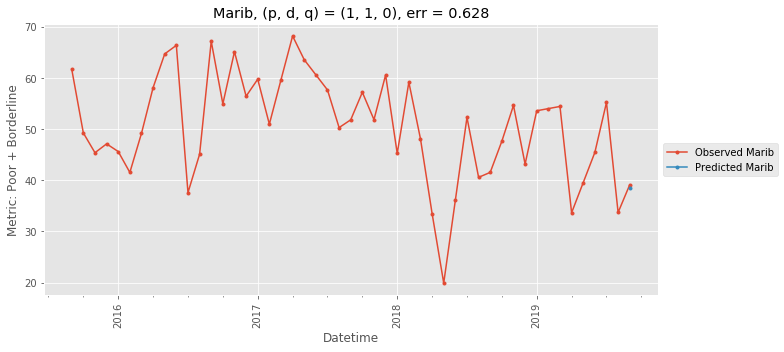

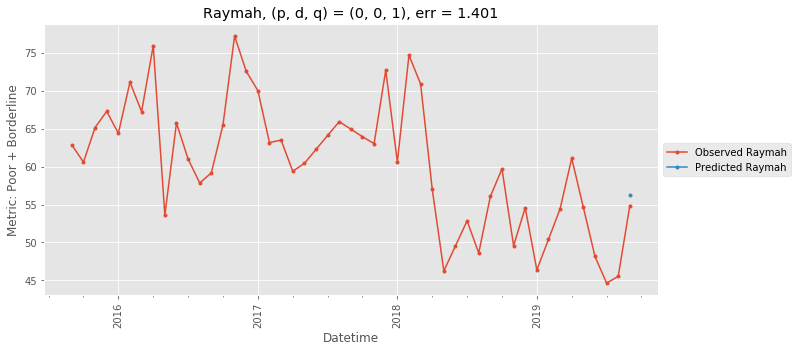

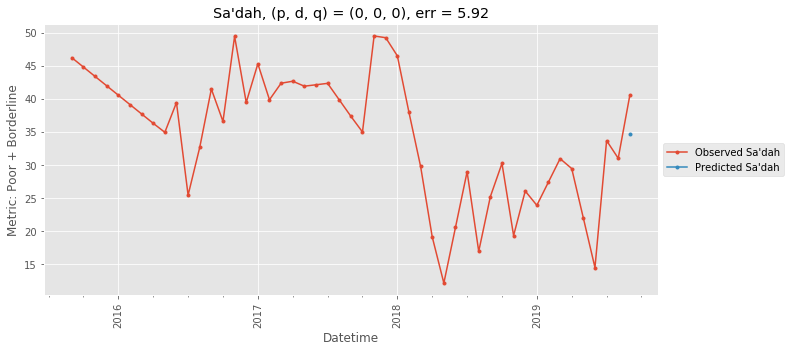

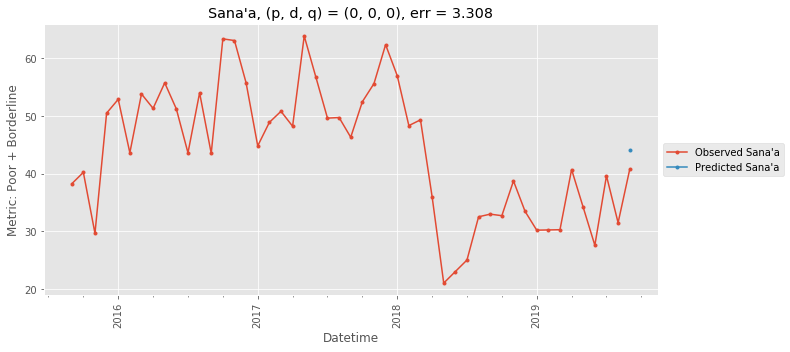

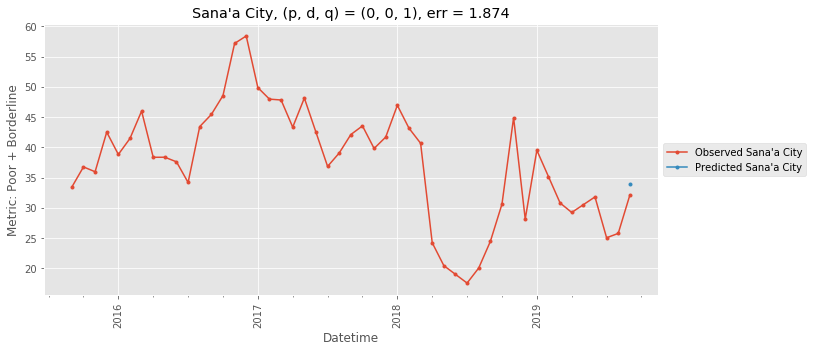

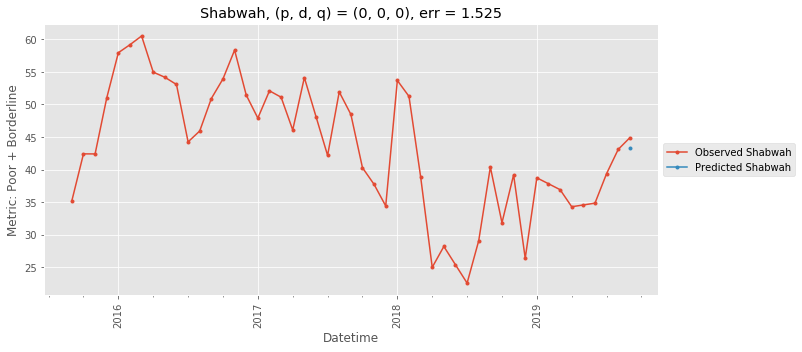

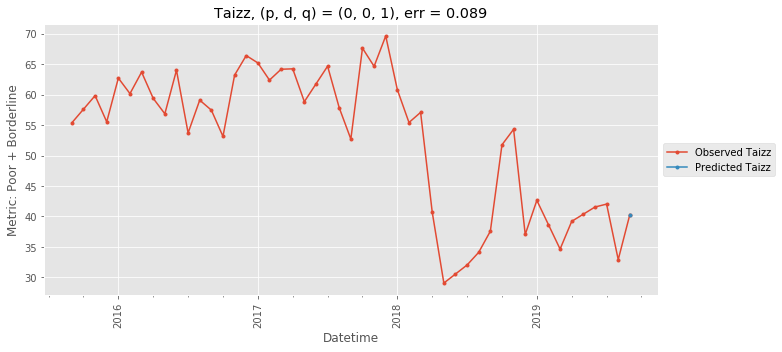

In [28]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "(p, d, q) = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [29]:
results_forecast["ARIMA"] = err

## 5.  Seasonal Autoregressive Integrated Moving Average (ARIMA) Forecasting

The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time-series data that may contain trend and seasonal components, unlike the ARIMA model. It is an effective approach for time-series forecasting, although it requires careful analysis and domain expertise in order to configure the seven or more model hyperparameters. There are three trend parameters that require configuration, they are the same as the ARIMA model; specifically p, d and q. There are four seasonal elements that are not part of ARIMA that must be configured; they are: P, D and Q. Together, the notation for a SARIMA model is specified as: SARIMA(p,d,q)(P,D,Q)m. Where the specifically chosen hyperparameters for a model are specified. Importantly, the m parameter influences the P, D, and Q parameters. For example, an m of 12 for monthly data suggests a yearly seasonal cycle. 

An alternative approach to configuring the model is to grid search a suite of hyperparameter configurations in order to discover what works best. 

In [29]:
import statsmodels.api as sm

In [30]:
def evaluate_SARIMA_model(time_series, arima_order, seasonal_order):
    for i in range(num_predictions):
        # Make prediction.
        model = sm.tsa.statespace.SARIMAX(time_series, order = arima_order,
                                          seasonal_order = seasonal_order,
                                          enforce_stationarity = False,
                                          enforce_invertibility = False)
        model_fit = model.fit()
        y_hat = model_fit.predict(len(time_series), len(time_series))[0]
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = np.sqrt(mean_squared_error(y_true = df_test[time_series.name], 
                                       y_pred = y_hats))
    return error, arima_order, seasonal_order, y_hats

In [31]:
def SARIMA_forecast(time_series):
    # Grid search of the p, d, q and P, D, Q parameters of the SARIMA model.
    p = d = q = range(0, 2)
    # All the combination of the parameters.
    arima_orders = list(itertools.product(p, d, q))
    seasonal_orders = [(x[0], x[1], x[2], 12) for x in arima_orders]
    best_score, best_arima_order, best_seasonal_order, best_yhats = float("inf"), None, None, None
    with tqdm(total = len(arima_orders), disable = False, leave = False, desc = time_series.name, ascii = True) as progress_bar: 
        for arima_order_ in arima_orders:
            for seasonal_order_ in seasonal_orders:
                try:
                    error, arima_order, seasonal_order, y_hats = evaluate_SARIMA_model(time_series, arima_order_, 
                                                                                       seasonal_order_)
                    if error < best_score:
                        best_score, best_arima_order, best_seasonal_order, best_yhats = error, arima_order, seasonal_order, y_hats
                except:
                    continue    
                    
            progress_bar.update(1) 
      
    return best_score, best_arima_order, best_seasonal_order, best_yhats

In [32]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(SARIMA_forecast)
err = np.mean([x[0] for x in results])
err

Abyan:   0%|                                                                                     | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Abyan:  75%|#########################################################7                   | 6/8 [00:31<00:12,  6.13s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Aden:  38%|#############################2                                                | 3/8 [00:09<00:15,  3.11s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Aden:  50%|#######################################                                       | 4/8 [00:13<00:14,  3.51s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Al Bayda:  38%|###########################7                                              | 3/8 [00:10<00:15,  3.19s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Al Hudaydah:  88%|##############################################################1        | 7/8 [00:31<00:04,  4.64s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Al Jawf:   0%|                                                                                   | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Al Maharah:  62%|#############################################                           | 5/8 [00:20<00:12,  4.17s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Amran:  75%|#########################################################7                   | 6/8 [00:21<00:08,  4.09s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Dhamar:   0%|                                                                                    | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

Dhamar:  75%|#########################################################                   | 6/8 [00:22<00:08,  4.05s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

Dhamar:  88%|##################################################################5         | 7/8 [00:27<00:04,  4.44s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Hadramaut:   0%|                                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Hadramaut:  12%|#########1                                                               | 1/8 [00:03<00:21,  3.00s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Ibb:   0%|                                                                                       | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Ibb:  12%|#########8                                                                     | 1/8 [00:02<00:20,  2.97s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

Ibb:  25%|###################7                                                           | 2/8 [00:07<00:20,  3.44s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Marib:  25%|###################2                                                         | 2/8 [00:08<00:20,  3.48s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to c

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Sana'a:  75%|#########################################################                   | 6/8 [00:26<00:08,  4.48s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Sana'a City:   0%|                                                                               | 0/8 [00:00<?, ?it/s]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Sana'a City:  50%|###################################5                                   | 4/8 [00:15<00:14,  3.73s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
Sana'a City:  62%|############################################3                          | 5/8 [00:18<00:11,  3.77s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

Sana'a City:  75%|#####################################################2                 | 6/8 [00:23<00:08,  4.09s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

Sana'a City:  88%|##############################################################1        | 7/8 [00:27<00:04,  4.02s/it]C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization f

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was pr

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

5.9990546571346055

In [27]:
for result in results:
    serie_predicted = result[3]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "(p, d, q) = " + str(result[1]) + ", (P, D, Q) = " + str(result[2]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

IndexError: tuple index out of range

In [34]:
results_forecast["SARIMA"] = err

## 6.  Exponential Smoothing (ETS) Forecasting

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
def evaluate_ETS_model(time_series, ets_order):
    t, d, s, p, b, r = ets_order
    for i in range(num_predictions):
        # Make prediction.
        model = ExponentialSmoothing(time_series, trend = t, damped = d, seasonal = s, seasonal_periods = p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_hat = model_fit.predict(len(time_series), len(time_series))
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = np.sqrt(mean_squared_error(y_true = df_test[time_series.name], 
                                       y_pred = y_hats))
    return error, ets_order, y_hats

In [ ]:
def ETS_forecast(time_series):
    # Grid search of the parameters for the ETS model.
    t_params = ["add", "mul", None]
    d_params = [True, False]
    s_params = ["add", "mul", None]
    p_params = [None]
    b_params = [True, False]
    r_params = [True, False]
    # All the combination of the parameters.
    ets_orders = list(itertools.product(t_params, d_params, s_params, p_params, b_params, r_params))
    best_score, best_ets_order = float("inf"), None
    with tqdm(total = len(ets_orders), disable = False, leave = False, desc = time_series.name, ascii = True) as progress_bar: 
        for ets_order in ets_orders:
            try:
                error, ets_order, y_hats = evaluate_ETS_model(time_series, ets_order)
                if error < best_score:
                    best_score, best_ets_order, best_y_hats = error, ets_order, y_hats
            except:
                continue  
                
            progress_bar.update(1) 
        
    return best_score, best_ets_order, best_y_hats

In [ ]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(ETS_forecast)
err = np.mean([x[0] for x in results])
err

In [ ]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "(p, d, q) = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [ ]:
results_forecast["ETS"] = err

In [35]:
results_forecast = dict(sorted(results_forecast.items(), key = lambda x: x[1]))
plt.barh(*zip(*results_forecast.items()))
plt.show()

ValueError: setting an array element with a sequence.